In [1]:
## import public packages
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import mlab
from datetime import datetime
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import multivariate_normal
# from __future__ import 
import torch
from torch.autograd import Variable

## import self-written packages 
from module_test import *
from util import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

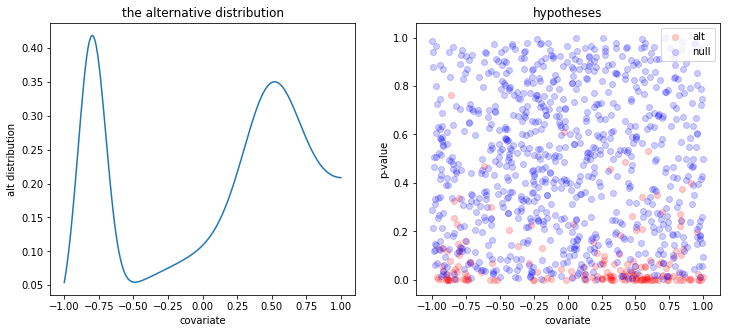

In [2]:
## generating a 1d toy data 
p,x,h=toy_data_1d(vis=1)

In [33]:
## testing the Storey BH method
n_rej,t_rej,pi0_hat=storey_bh(p,alpha=0.2,vis=1)

### Summary ###
method: Storey BH
# rejections: 1505
rejection threshold: 0.0379525376053
null estimate: 0.7915
### End Summary ###


In [54]:
## maybe we should use pytorch
def PrimFDR_1d(p,x,alpha=0.2,h=None):    
    torch.manual_seed(24)
    n_itr    = 20000
    L        = 2
    lambda0  = 100
    lambda1  = 10000
    loss_rec = np.zeros([n_itr],dtype=float)
 
    p     = Variable(torch.from_numpy(p).float(),requires_grad=False)
    x     = Variable(torch.from_numpy(x).float(),requires_grad=False)
    
    ## initialization    
    a     = Variable(torch.Tensor([-10]),requires_grad=True)
    b     = Variable(torch.Tensor([0]),requires_grad=True)
    w     = Variable(torch.zeros(L)-5,requires_grad=True)
    mu    = Variable(torch.rand(L)*2-1,requires_grad=True)
    sigma = Variable(torch.zeros(L)+0.5,requires_grad=True)
    
    optimizer = torch.optim.Adam([a,b,w,mu,sigma],lr=0.0001)
#     optimizer = torch.optim.Adam([a,b],lr=0.0005)
    optimizer.zero_grad()
    
    for l in range(n_itr):
        ## calculating the model
#         t = torch.exp(x*b+a)
        t = torch.exp(x*b+a)
        for i in range(L):
            t = t+torch.sigmoid(w[i])*torch.exp(-(x-mu[i])**2/sigma[i])
        #t = t.clamp(min=0)
        
        loss1 = -torch.mean(torch.sigmoid(lambda0*(t-p)))
        loss2 = torch.exp(lambda1*(torch.mean(t)-alpha*torch.mean(torch.sigmoid(lambda0*(t-p)))))
        #print(alpha*torch.mean(torch.sigmoid(lambda0*(t-p)))-torch.mean(t))
        #loss2 = -torch.log(alpha*torch.mean(torch.sigmoid(lambda0*(t-p)))-torch.mean(t))
        loss  = loss1+loss2
        
        ## backprop
        loss.backward()
        optimizer.step()
        
        ## show the result 
        loss_rec[l] = loss.data.numpy()
        
        if l%2000==0:
            print('mean t: ', np.mean(t.data.numpy()))
            print('mean discovery: ', np.mean(t.data.numpy()>p.data.numpy()))
            print('loss1: ',loss1.data.numpy())
            print('loss2: ',loss2.data.numpy())
            print('n_rej: ',np.sum(t.data.numpy()>p.data.numpy()))
            print('Estimated FDP: %s'%str((torch.mean(t)/torch.mean(torch.sigmoid(lambda0*(t-p)))).data.numpy()))
            print('FDP: %s'%str( np.sum((h==0)*(p.data.numpy()<t.data.numpy()))/np.sum(p.data.numpy()<t.data.numpy())))
            print ('a: %s,b: %s'%(str(a.data.numpy()),str(b.data.numpy())))
            print ('w0: %s, mu0: %s, sigma0: %s'%(str(w.data.numpy()[0]),str(mu.data.numpy()[0]),str(sigma.data.numpy()[0])))
            print ('w1: %s, mu1: %s, sigma1: %s'%(str(w.data.numpy()[1]),str(mu.data.numpy()[1]),str(sigma.data.numpy()[1])))
            plt.figure()
            plot_t(t.data.numpy(),x.data.numpy())
            plt.show()
    
    
    plt.figure()
    plt.plot(loss_rec)
    plt.show()
    
    p = p.data.numpy()
    t = t.data.numpy()
    n_rej=np.sum(p<t)    
        
    return n_rej,t

mean t:  0.00743922
mean discovery:  0.0769
loss1:  [-0.0678933]
loss2:  [  2.17144345e-27]
n_rej:  769
Estimated FDP: [ 0.10957222]
FDP: 0.0884265279584
a: [-9.99989986],b: [  9.72582566e-05]
w0: -4.9999, mu0: 0.528758, sigma0: 0.5001
w1: -4.9999, mu1: -0.249793, sigma1: 0.5001


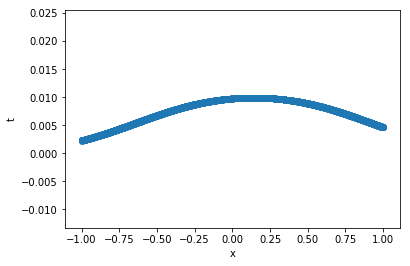

mean t:  0.0127397
mean discovery:  0.0953
loss1:  [-0.08333056]
loss2:  [  8.87187768e-18]
n_rej:  953
Estimated FDP: [ 0.15288205]
FDP: 0.121720881427
a: [-9.69238377],b: [ 0.32266101]
w0: -4.6905, mu0: 0.25086, sigma0: 0.805438
w1: -4.68749, mu1: 0.0527133, sigma1: 0.798757


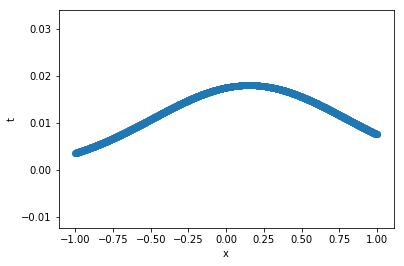

mean t:  0.0179773
mean discovery:  0.1101
loss1:  [-0.09827383]
loss2:  [  5.18569720e-08]
n_rej:  1101
Estimated FDP: [ 0.18293057]
FDP: 0.147138964578
a: [-9.41837692],b: [ 0.61780715]
w0: -4.41483, mu0: 0.0631445, sigma0: 1.07262
w1: -4.40847, mu1: 0.285695, sigma1: 1.05328


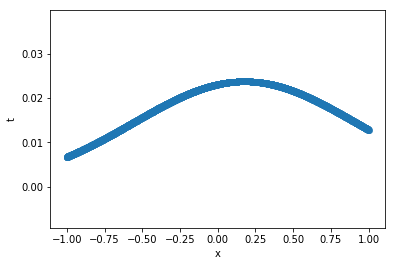

mean t:  0.020071
mean discovery:  0.1165
loss1:  [-0.10530543]
loss2:  [  5.01104332e-05]
n_rej:  1165
Estimated FDP: [ 0.19059756]
FDP: 0.155364806867
a: [-9.25042915],b: [ 0.83878732]
w0: -4.27695, mu0: 0.264636, sigma0: 1.27751
w1: -4.25611, mu1: 0.569772, sigma1: 1.24029


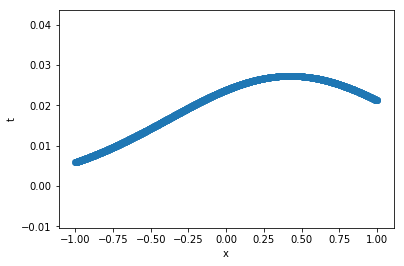

mean t:  0.0205358
mean discovery:  0.1177
loss1:  [-0.10728213]
loss2:  [ 0.00010042]
n_rej:  1177
Estimated FDP: [ 0.19141874]
FDP: 0.161427357689
a: [-9.09054852],b: [ 1.05932593]
w0: -4.20188, mu0: 0.502116, sigma0: 1.47508
w1: -4.13481, mu1: 0.794165, sigma1: 1.41837


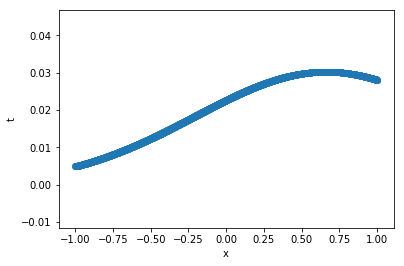

mean t:  0.0206914
mean discovery:  0.1182
loss1:  [-0.10805488]
loss2:  [ 0.00010143]
n_rej:  1182
Estimated FDP: [ 0.1914894]
FDP: 0.164128595601
a: [-8.90797901],b: [ 1.27196729]
w0: -4.13664, mu0: 0.722897, sigma0: 1.67302
w1: -3.98233, mu1: 1.00612, sigma1: 1.60314


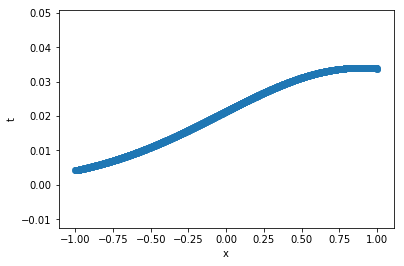

mean t:  0.0209672
mean discovery:  0.1185
loss1:  [-0.10888612]
loss2:  [ 0.00030333]
n_rej:  1185
Estimated FDP: [ 0.1925604]
FDP: 0.164556962025
a: [-8.71278286],b: [ 1.47860348]
w0: -4.05967, mu0: 0.932107, sigma0: 1.8719
w1: -3.80045, mu1: 1.21107, sigma1: 1.79446


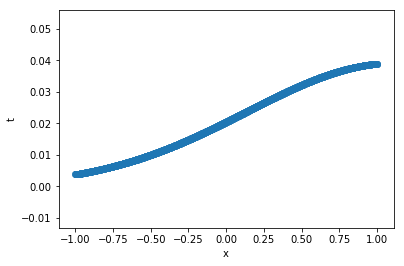

mean t:  0.0211918
mean discovery:  0.1189
loss1:  [-0.10946765]
loss2:  [ 0.00089638]
n_rej:  1189
Estimated FDP: [ 0.19358975]
FDP: 0.162321278385
a: [-8.51381302],b: [ 1.67930114]
w0: -3.98079, mu0: 1.13499, sigma0: 2.07181
w1: -3.60675, mu1: 1.41236, sigma1: 1.9906


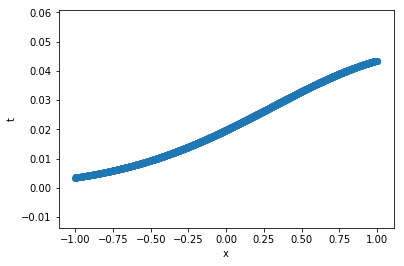

mean t:  0.0211372
mean discovery:  0.1185
loss1:  [-0.10933763]
loss2:  [ 0.00067334]
n_rej:  1185
Estimated FDP: [ 0.19332045]
FDP: 0.160337552743
a: [-8.32476425],b: [ 1.86153924]
w0: -3.91364, mu0: 1.33609, sigma0: 2.27204
w1: -3.41339, mu1: 1.61281, sigma1: 2.18871


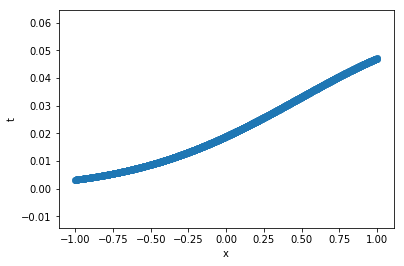

mean t:  0.020939
mean discovery:  0.118
loss1:  [-0.10884897]
loss2:  [ 0.00024657]
n_rej:  1180
Estimated FDP: [ 0.19236752]
FDP: 0.156779661017
a: [-8.15371513],b: [ 1.9982239]
w0: -3.8497, mu0: 1.53582, sigma0: 2.4728
w1: -3.22066, mu1: 1.8126, sigma1: 2.38858


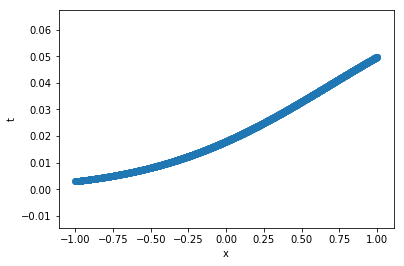

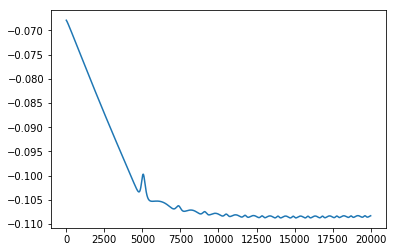

### Summary ###
method: perim_test_1d
# rejections: 1172
FDP: 0.156996587031
### End Summary ###


In [55]:
n_rej,t=PrimFDR_1d(p,x,alpha=0.2,h=h)

print("### Summary ###")
print("method: perim_test_1d")
print("# rejections: %s"%str(n_rej))
print("FDP: %s"%str( np.sum((h==0)*(p<t))/np.sum(p<t)))
print("### End Summary ###")

In [14]:
## 
print(np.sum(p<0.05))
print(np.mean((p<0.01)*(h==0)))

1694
0.0091


In [11]:
def test_t(x):
#     return 0.01+0.1*x    
    return 0.01

In [15]:
t=test_t(x)
print(np.mean(t))
print(np.mean((p<t)*(h==0)))

0.01
0.0091


In [13]:
t

0.01